### Задание 5.1

АА-тест проводился с '2022-10-26' по '2022-11-01'.

Нужно сделать симуляцию 10000 АА-тестов.

На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы.

Провести сравнение этих подвыборок t-testом.

In [32]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc ={'figure.figsize':(15,10)})

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221120'
    }

q = """
    SELECT
        exp_group,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM
        simulator_20221120.feed_actions
    WHERE
        toDate(time) BETWEEN '2022-10-26' AND '2022-11-01'
        AND exp_group in (2, 3)
    GROUP BY
        exp_group,
        user_id
    """


df = pandahouse.read_clickhouse(q, connection=connection)

In [30]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [23]:
# группы примерно одинакового размера

df[df['exp_group']==3].exp_group.count()

8569

In [24]:
df[df['exp_group']==2].exp_group.count()

8480

Text(0.5, 1.0, 'CTR distribution')

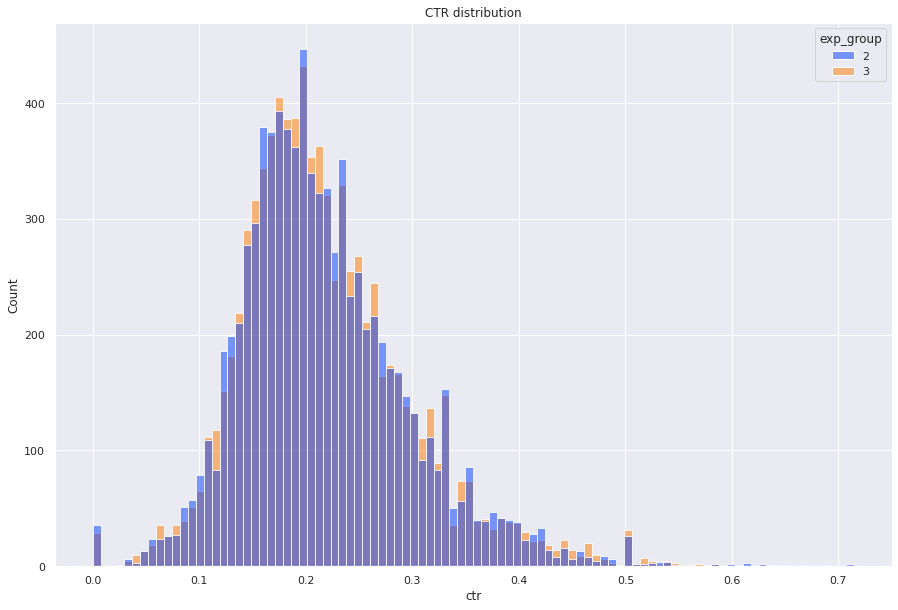

In [33]:
# гистограмма распредление CTR по группам 2 и 3

ax = sns.histplot(df, x = 'ctr', hue = 'exp_group', palette = 'bright', kde=False)
ax.set_title('CTR distribution')

In [34]:
# t-test

stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [36]:
A_gt_B = 0
for i in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 49.39 % случаев A > B. Должно получиться около 50%


#### 1. Построить гистограмму распределения получившихся 10000 p-values.

In [45]:
# 10000 AA-тестов по 500 юзеров без повторения

p_values = []

for i in range(10000):
    p_values.append(stats.ttest_ind(df[df.exp_group == 2].sample(500, replace = False).ctr,
                                    df[df.exp_group == 3].sample(500, replace = False).ctr,
                                    equal_var=False)[1])

Text(0.5, 0, 'p_value')

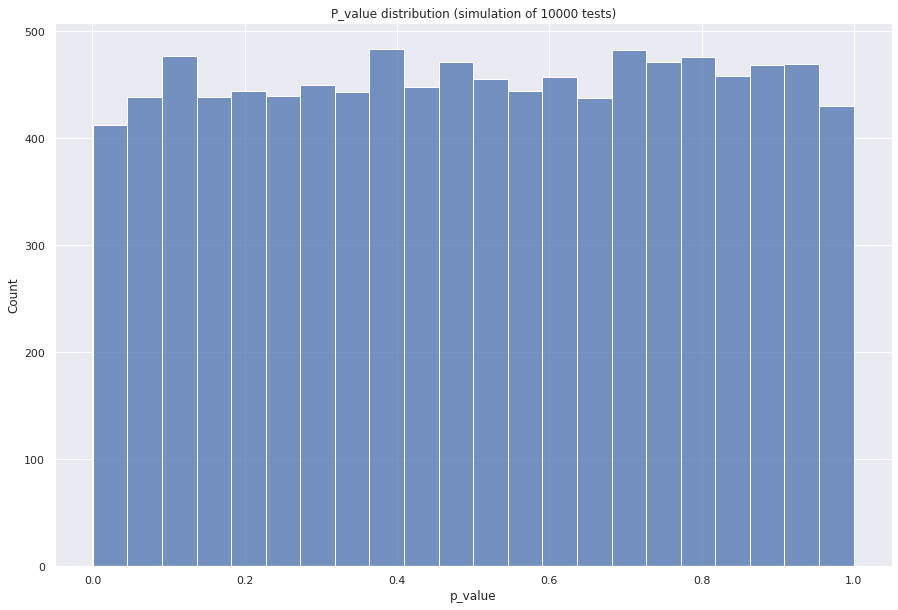

In [44]:
# построим гистограмму p_values

sns.histplot(data = p_values, palette = 'bright')
plt.title('P_value distribution (simulation of 10000 tests)')
plt.xlabel('p_value')

#### 2. Какой процент p-values оказался меньше либо равен 0.05?

In [78]:
p_value_percent = pd.DataFrame(data=p_values) \
    .rename(columns={0: 'p_values'}) \
    .query('p_values <= 0.05').shape[0]*100 / pd.DataFrame(data=p_values).shape[0]

In [80]:
print("{}% p-values оказался меньше либо равен 0.05".format(p_value_percent))

4.95% p-values оказался меньше либо равен 0.05


#### 3. Вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Из 10000 тестов, менее чем в 5% случаев p-value оказалось меньше либо равно 0.05. Нет оснований для отклонения H0 о равенстве средних в контрольной и тестовой группах. Считаем что наша система сплитирования работает корректно